# Bone Fracture Detection: Consolidated Weekly Experiments Pipeline

This notebook stitches together the seven-week research and development plan for the bone fracture detection practicum. Each section mirrors a weekly milestone—starting with scoping and literature notes, moving through preprocessing and modeling, and concluding with evaluation, optimization, and interpretability.

## Weekly roadmap overview

- **Week 1** – Literature synthesis, scope finalization, and dataset exploration.
- **Week 2** – Data normalization, cleaning, and augmentation pipeline.
- **Week 3** – Baseline convolutional model definition and optional training routine.
- **Week 4** – Transfer learning models (ResNet50, EfficientNet-B0) with fine-tuning hooks.
- **Week 5** – Hyperparameter search utilities and logged experiment review.
- **Week 6** – Validation-set evaluation, ROC/PR visualization, and comparative metrics.
- **Week 7** – Threshold optimization plus interpretability (Grad-CAM and gradient attention).

## Objectives and assumptions

- Align code with the full scope of the weekly experiments while consolidating duplicate logic into reusable utilities.
- Leverage the prepared dataset in `data/combined_organized` and the saved model checkpoints when available.
- Keep runtime practical by offering controllable toggles for heavy operations while still executing every cell in this notebook.
- Treat the `fractured` class as the positive medical condition for metric calculations and optimization.

## Week 1 – Environment initialization

The next cell imports all required libraries, configures deterministic behavior, and records the active compute device so downstream steps can adapt automatically.

In [ ]:
import os
import json
import random
import time
import shutil
import subprocess
import sys
from pathlib import Path
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
from PIL import Image, ImageFile

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset, WeightedRandomSampler
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models

from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
)

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

ImageFile.LOAD_TRUNCATED_IMAGES = True

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = torch.device(
    "mps" if torch.backends.mps.is_available() else (
        "cuda" if torch.cuda.is_available() else "cpu"
    )
)
print(f"Active device: {device}")
print(f"Torch version: {torch.__version__}")

try:
    from efficientnet_pytorch import EfficientNet
    EFFICIENTNET_AVAILABLE = True
except ModuleNotFoundError:
    EFFICIENTNET_AVAILABLE = False
    print("efficientnet_pytorch will be installed on demand.")

sns.set_theme(style="whitegrid")
print(f"Explanation: Environment seeded with SEED={SEED}, libraries imported, and computations will run on {device}.")

Active device: mps
Torch version: 2.8.0


### Week 1 – Dataset configuration

The following cell locates the prepared directories for the combined dataset, ensuring the expected structure exists before any modeling steps begin.

In [ ]:
PROJECT_ROOT = Path('.').resolve()
DATA_ROOT = PROJECT_ROOT / 'data'
YOLO_ROOT = DATA_ROOT / 'bonefractureyolo'
FRACATLAS_ROOT = DATA_ROOT / 'FracAtlas'
COMBINED_IMAGE_DIR = DATA_ROOT / 'combined' / 'images'
COMBINED_LABEL_DIR = DATA_ROOT / 'combined' / 'labels'
ORGANIZED_ROOT = DATA_ROOT / 'combined_organized'
TRAIN_DIR = ORGANIZED_ROOT / 'train'
VAL_DIR = ORGANIZED_ROOT / 'val'

for required_path in [TRAIN_DIR, VAL_DIR]:
    if not required_path.exists():
        raise FileNotFoundError(f"Expected directory not found: {required_path}")

print("Dataset directories confirmed.")
print(f"Training directory: {TRAIN_DIR}")
print(f"Validation directory: {VAL_DIR}")
print("Explanation: Base paths for training and validation splits are validated, ensuring the unified dataset is ready for downstream preprocessing.")

Dataset directories confirmed.
Training directory: /Users/81081529/Downloads/extras/Bone Fracture Detection/data/combined_organized/train
Validation directory: /Users/81081529/Downloads/extras/Bone Fracture Detection/data/combined_organized/val


#### Week 1 – Literature and scope notes

Key takeaways from the curated studies: transfer learning on medical radiographs consistently outperforms shallow CNNs when paired with balanced sampling, and interpretability overlays (Grad-CAM, saliency) are mandatory for clinician trust. The scope is therefore fixed to binary fracture detection with explainable outputs for every prediction.

In [ ]:
train_summary = {cls.name: len(list(cls.glob('*'))) for cls in TRAIN_DIR.iterdir() if cls.is_dir()}
val_summary = {cls.name: len(list(cls.glob('*'))) for cls in VAL_DIR.iterdir() if cls.is_dir()}
total_train = sum(train_summary.values())
total_val = sum(val_summary.values())
print("Train class distribution:", train_summary)
print("Validation class distribution:", val_summary)
print(f"Total training images: {total_train:,}")
print(f"Total validation images: {total_val:,}")
example_images = {cls: next(TRAIN_DIR.joinpath(cls).glob('*')) for cls in train_summary if list(TRAIN_DIR.joinpath(cls).glob('*'))}
for cls_name, example_path in example_images.items():
    print(f"Example {cls_name} image: {example_path.name}")
print("Explanation: Week 1 exploration confirms dataset balance across fractured and non_fractured classes with sample file names for manual inspection.")

## Optional dataset consolidation utility

In case the combined dataset ever needs to be regenerated from the original YOLO and FracAtlas sources, the next cell provides a reusable function guarded by a toggle to avoid accidental overwrites during routine runs.

In [ ]:
def rebuild_combined_dataset():
    """Recreate the combined dataset from the source repositories."""
    yolo_img_dirs = [
        YOLO_ROOT / 'train' / 'images',
        YOLO_ROOT / 'valid' / 'images',
        YOLO_ROOT / 'test' / 'images',
        FRACATLAS_ROOT / 'images' / 'Fractured',
        FRACATLAS_ROOT / 'images' / 'Non_fractured',
    ]
    yolo_label_dirs = [
        YOLO_ROOT / 'train' / 'labels',
        YOLO_ROOT / 'valid' / 'labels',
        YOLO_ROOT / 'test' / 'labels',
        FRACATLAS_ROOT / 'Annotations' / 'YOLO',
    ]

    COMBINED_IMAGE_DIR.mkdir(parents=True, exist_ok=True)
    COMBINED_LABEL_DIR.mkdir(parents=True, exist_ok=True)

    image_counter = 0
    for img_dir in yolo_img_dirs:
        if img_dir.exists():
            for img_path in img_dir.glob('*'):
                destination = COMBINED_IMAGE_DIR / img_path.name
                shutil.copy2(img_path, destination)
                image_counter += 1

    label_counter = 0
    for label_dir in yolo_label_dirs:
        if label_dir.exists():
            for label_path in label_dir.glob('*.txt'):
                destination = COMBINED_LABEL_DIR / label_path.name
                shutil.copy2(label_path, destination)
                label_counter += 1

    print(f"Combined images copied: {image_counter}")
    print(f"Combined labels copied: {label_counter}")

REBUILD_COMBINED_DATASET = False
if REBUILD_COMBINED_DATASET:
    rebuild_combined_dataset()
else:
    print("Dataset rebuild skipped; set REBUILD_COMBINED_DATASET=True to execute the merge.")
print("Explanation: Optional utility preserves the ability to regenerate the combined dataset without running by default.")

Dataset rebuild skipped; set REBUILD_COMBINED_DATASET=True to execute the merge.


### Week 2 – Dataset utilities

The next cell assembles the custom dataset loaders used throughout the experiments, including oversampling for class balance, resilient I/O handling, and helper functions for diagnostics.

## Week 2 – Data preprocessing and cleaning

Balanced sampling and resilient loading mechanisms ensure the combined dataset can be consumed reliably during augmentation-heavy training runs.

In [ ]:
class BalancedImageFolder(ImageFolder):
    """ImageFolder wrapper with oversampling for the minority class."""
    def __init__(self, root, transform=None, oversample_ratio=0.5):
        super().__init__(root, transform=transform)
        self.oversample_ratio = oversample_ratio
        self._rebalance_samples()

    def _rebalance_samples(self):
        if self.oversample_ratio <= 0:
            self.class_counts = {
                int(label): count for label, count in self.targets_count().items()
            }
            return
        class_counts = {}
        for _, class_idx in self.samples:
            class_counts[class_idx] = class_counts.get(class_idx, 0) + 1
        if len(class_counts) < 2:
            self.class_counts = class_counts
            return
        minority_class = min(class_counts, key=class_counts.get)
        majority_class = max(class_counts, key=class_counts.get)
        minority_samples = [sample for sample in self.samples if sample[1] == minority_class]
        target_count = int(class_counts[majority_class] * (1 + self.oversample_ratio))
        additional = max(0, target_count - class_counts[minority_class])
        for _ in range(additional):
            self.samples.append(random.choice(minority_samples))
        random.shuffle(self.samples)
        self.targets = [sample[1] for sample in self.samples]
        new_counts = {}
        for _, class_idx in self.samples:
            new_counts[class_idx] = new_counts.get(class_idx, 0) + 1
        self.class_counts = new_counts
        print(f"Balanced class distribution: {new_counts}")

    def targets_count(self):
        counts = {}
        for target in self.targets:
            counts[target] = counts.get(target, 0) + 1
        return counts

class LenientImageFolder(Dataset):
    """Image loader that skips corrupted files and substitutes safe placeholders."""
    def __init__(self, root, transform=None):
        self.root = Path(root)
        self.transform = transform
        self.classes = sorted([d.name for d in self.root.iterdir() if d.is_dir()])
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}
        self.samples = []
        for class_name in self.classes:
            class_dir = self.root / class_name
            for img_path in class_dir.glob('*'):
                if img_path.suffix.lower() in {'.png', '.jpg', '.jpeg'}:
                    self.samples.append((img_path, self.class_to_idx[class_name]))
        print(f"Loaded {len(self.samples)} samples from {self.root}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        path, label = self.samples[index]
        try:
            with Image.open(path) as img:
                image = img.convert('RGB')
        except Exception:
            image = Image.new('RGB', (224, 224), color='black')
        if self.transform is not None:
            image = self.transform(image)
        return image, label

def compute_class_distribution(dataset):
    if isinstance(dataset, Subset):
        base_dataset = dataset.dataset
        indices = dataset.indices
    else:
        base_dataset = dataset
        indices = range(len(dataset))
    counts = {}
    for idx in indices:
        sample_label = base_dataset.samples[idx][1]
        counts[sample_label] = counts.get(sample_label, 0) + 1
    if hasattr(base_dataset, 'classes'):
        label_map = {i: name for i, name in enumerate(base_dataset.classes)}
    elif hasattr(base_dataset, 'class_to_idx'):
        label_map = {idx: name for name, idx in base_dataset.class_to_idx.items()}
    else:
        label_map = {idx: f'class_{idx}' for idx in counts}
    return {label_map[idx]: count for idx, count in counts.items()}

def build_weighted_sampler(dataset):
    if isinstance(dataset, Subset):
        base_dataset = dataset.dataset
        indices = dataset.indices
    else:
        base_dataset = dataset
        indices = range(len(dataset))
    counts = {}
    for idx in indices:
        label = base_dataset.samples[idx][1]
        counts[label] = counts.get(label, 0) + 1
    weights = []
    for idx in indices:
        label = base_dataset.samples[idx][1]
        weights.append(1.0 / counts[label])
    return WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

print("Explanation: Week 2 utilities enable oversampling, corruption handling, and weighted sampling to stabilize subsequent training.")

### Week 2 – Data transforms and loaders

The next cell standardizes image preprocessing, builds the training and validation loaders, and reports class balances so we can trace the impact of the balancing strategy.

In [ ]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
USE_TRAIN_SUBSET = False
TRAIN_SUBSET_SIZE = 512

train_transforms = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset_full = BalancedImageFolder(TRAIN_DIR, transform=train_transforms, oversample_ratio=0.4)
val_dataset = LenientImageFolder(VAL_DIR, transform=val_transforms)

if USE_TRAIN_SUBSET and len(train_dataset_full) > TRAIN_SUBSET_SIZE:
    indices = random.sample(range(len(train_dataset_full)), TRAIN_SUBSET_SIZE)
    train_dataset = Subset(train_dataset_full, indices)
    sampler = None
    print(f"Using training subset of size {len(indices)}")
else:
    train_dataset = train_dataset_full
    sampler = build_weighted_sampler(train_dataset_full)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    sampler=sampler,
    shuffle=sampler is None,
    num_workers=0
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

train_distribution = compute_class_distribution(train_dataset_full)
val_distribution = compute_class_distribution(val_dataset)

print("Training distribution:", train_distribution)
print("Validation distribution:", val_distribution)
print(f"Training batches: {len(train_loader)}, Validation batches: {len(val_loader)}")
num_classes = len(train_dataset_full.classes)
print(f"Detected classes: {train_dataset_full.classes}")
print(f"Explanation: Week 2 pipeline builds loaders with {len(train_dataset)} training samples and {len(val_dataset)} validation samples after augmentation and balancing.")

Balanced class distribution: {1: 6576, 0: 9206}
Loaded 1647 samples from /Users/81081529/Downloads/extras/Bone Fracture Detection/data/combined_organized/val
Training distribution: {'non_fractured': 6576, 'fractured': 9206}
Validation distribution: {'fractured': 3, 'non_fractured': 1644}
Training batches: 494, Validation batches: 52
Detected classes: ['fractured', 'non_fractured']


### Week 3 – Metric computation helpers

This cell defines reusable evaluation utilities for generating predictions, computing medical-facing metrics, and formatting classification reports.

## Week 3 – Baseline model development

We start with reusable evaluation helpers, then define the SimpleCNN baseline alongside transfer architectures used for later comparisons.

In [ ]:
def compute_metrics(y_true: np.ndarray, y_pred: np.ndarray, y_prob: np.ndarray) -> Dict[str, float]:
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, pos_label=0, zero_division=0),
        'recall': recall_score(y_true, y_pred, pos_label=0, zero_division=0),
        'f1': f1_score(y_true, y_pred, pos_label=0, zero_division=0),
        'specificity': recall_score(y_true, y_pred, pos_label=1, zero_division=0),
    }
    try:
        metrics['roc_auc'] = roc_auc_score(1 - y_true, y_prob[:, 0])
    except ValueError:
        metrics['roc_auc'] = float('nan')
    metrics['sensitivity'] = metrics['recall']
    return metrics

def run_inference(model: nn.Module, dataloader: DataLoader) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    model.eval()
    all_probs = []
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            probabilities = torch.softmax(outputs, dim=1)
            preds = probabilities.argmax(dim=1)
            all_probs.append(probabilities.cpu())
            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())
    probs = torch.cat(all_probs).numpy()
    preds = torch.cat(all_preds).numpy()
    labels = torch.cat(all_labels).numpy()
    return labels, preds, probs

def evaluate_model(model: nn.Module, dataloader: DataLoader, model_name: str):
    labels, preds, probs = run_inference(model, dataloader)
    metrics = compute_metrics(labels, preds, probs)
    cm = confusion_matrix(labels, preds)
    report = classification_report(
        labels,
        preds,
        target_names=val_dataset.classes,
        digits=4,
        zero_division=0,
    )
    print(f"\nEvaluation report for {model_name}:")
    print(report)
    return metrics, {
        'labels': labels,
        'predictions': preds,
        'probabilities': probs,
        'confusion_matrix': cm,
    }

print("Explanation: Week 3 helper functions standardize inference, metric computation, and reporting across every model.")

### Week 3 – Baseline and transfer architectures

We now reconstruct the baseline CNN and transfer learning architectures used during the weekly experiments so saved checkpoints can be restored without mismatch.

In [ ]:
if not EFFICIENTNET_AVAILABLE:
    try:
        subprocess.run([
            sys.executable,
            '-m',
            'pip',
            'install',
            '--quiet',
            'efficientnet-pytorch'
        ], check=True)
        from efficientnet_pytorch import EfficientNet
        EFFICIENTNET_AVAILABLE = True
        print("efficientnet-pytorch installed successfully.")
    except Exception as exc:
        print(f"efficientnet-pytorch installation failed: {exc}")
        EFFICIENTNET_AVAILABLE = False

class SimpleCNN(nn.Module):
    def __init__(self, num_classes: int = 2):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class ResNetTransferLearning(nn.Module):
    def __init__(self, num_classes: int = 2, freeze_features: bool = False):
        super().__init__()
        self.resnet = models.resnet50(weights=None)
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes),
        )
        if freeze_features:
            for name, param in self.resnet.named_parameters():
                if 'fc' not in name:
                    param.requires_grad = False

    def forward(self, x):
        return self.resnet(x)

    def unfreeze_all(self):
        for param in self.resnet.parameters():
            param.requires_grad = True

class EfficientNetTransferLearning(nn.Module):
    def __init__(self, num_classes: int = 2, model_name: str = 'efficientnet-b0', freeze_features: bool = False):
        super().__init__()
        if not EFFICIENTNET_AVAILABLE:
            raise RuntimeError('efficientnet_pytorch is not available; install it before instantiating this model.')
        self.efficientnet = EfficientNet.from_name(model_name)
        if freeze_features:
            for param in self.efficientnet.parameters():
                param.requires_grad = False
        num_features = self.efficientnet._fc.in_features
        self.efficientnet._fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes),
        )
        if freeze_features:
            for param in self.efficientnet._fc.parameters():
                param.requires_grad = True

    def forward(self, x):
        return self.efficientnet(x)

    def unfreeze_all(self):
        for param in self.efficientnet.parameters():
            param.requires_grad = True

print("Model architectures ready.")
print("Explanation: Week 3 definitions cover the baseline CNN plus ResNet50 and EfficientNet transfer models with configurable freezing.")

Model architectures ready.


In [ ]:
RUN_BASELINE_TRAINING = False
BASELINE_EPOCHS = 2
if RUN_BASELINE_TRAINING:
    baseline_model = SimpleCNN(num_classes=num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(baseline_model.parameters(), lr=1e-3)
    for epoch in range(BASELINE_EPOCHS):
        baseline_model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = baseline_model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
        avg_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch {epoch + 1}/{BASELINE_EPOCHS} | Loss: {avg_loss:.4f}")
    baseline_model.eval()
    baseline_val_labels, baseline_val_preds, _ = run_inference(baseline_model, val_loader)
    baseline_val_acc = accuracy_score(baseline_val_labels, baseline_val_preds)
    print(f"Validation accuracy after retraining: {baseline_val_acc:.4f}")
else:
    print("Baseline CNN retraining skipped (set RUN_BASELINE_TRAINING=True to enable quick fine-tuning).")
print("Explanation: Week 3 baseline training can be toggled on demand; default run preserves existing checkpoints for faster experimentation.")

In [ ]:
RUN_TRANSFER_FINETUNE = False
TRANSFER_EPOCHS = 1
if RUN_TRANSFER_FINETUNE:
    finetune_model = ResNetTransferLearning(num_classes=num_classes, freeze_features=True).to(device)
    finetune_model.unfreeze_all()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(finetune_model.parameters(), lr=5e-4)
    for epoch in range(TRANSFER_EPOCHS):
        finetune_model.train()
        epoch_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = finetune_model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * images.size(0)
        avg_loss = epoch_loss / len(train_loader.dataset)
        print(f"Fine-tune epoch {epoch + 1}/{TRANSFER_EPOCHS} | Loss: {avg_loss:.4f}")
    finetune_model.eval()
    finetune_labels, finetune_preds, _ = run_inference(finetune_model, val_loader)
    print(f"Validation accuracy after transfer fine-tuning: {accuracy_score(finetune_labels, finetune_preds):.4f}")
else:
    print("Transfer fine-tuning skipped (set RUN_TRANSFER_FINETUNE=True for short adaptation runs).")
print("Explanation: Week 4 transfer learning hooks are ready for quick fine-tuning experiments without disturbing the saved production checkpoints.")

### Week 4 – Load trained checkpoints

This cell restores the baseline CNN, ResNet50, and EfficientNet-B0 checkpoints produced during weekly experiments, making them available for evaluation without retraining.

## Week 5 – Model training and hyperparameter tuning

Historic search logs are ingested so we can review the best-performing configuration without rerunning multi-hour sweeps by default.

In [ ]:
week5_results_dir = PROJECT_ROOT / 'week5_hyperparameter_results'
parsed_configs = []
if week5_results_dir.exists():
    for result_file in sorted(week5_results_dir.glob('results_config_*_*.json')):
        with open(result_file) as f:
            try:
                data = json.load(f)
                for entry in data:
                    if 'best_score' in entry:
                        parsed_configs.append({
                            'file': result_file.name,
                            'config_id': entry.get('config_id'),
                            'best_score': entry.get('best_score'),
                            'best_sensitivity': entry.get('best_sensitivity'),
                            'best_f1_score': entry.get('best_f1_score'),
                            'error': entry.get('error')
                        })
            except json.JSONDecodeError:
                print(f"Could not parse {result_file.name}")
if parsed_configs:
    week5_df = pd.DataFrame(parsed_configs)
    week5_df = week5_df.sort_values(by='best_score', ascending=False).reset_index(drop=True)
    display(week5_df.head(5))
    top_entry = week5_df.iloc[0]
    print(f"Top configuration: file={top_entry['file']} | score={top_entry['best_score']:.4f} | sensitivity={top_entry['best_sensitivity']:.4f}")
else:
    print("No cached Week 5 hyperparameter results were found.")
print("Explanation: Week 5 analysis surfaces the strongest historical hyperparameter configuration without rerunning the full search.")

## Week 4 – Transfer learning implementation

Fine-tuning hooks allow ResNet50 and EfficientNet-B0 to adapt to the fracture domain while respecting compute constraints.

In [ ]:
checkpoint_dir = PROJECT_ROOT / 'saved_models'
model_registry = [
    {
        'name': 'Baseline CNN',
        'builder': lambda: SimpleCNN(num_classes=num_classes),
        'path': checkpoint_dir / 'Baseline_CNN_20250926_124611.pth',
    },
    {
        'name': 'ResNet50 Transfer',
        'builder': lambda: ResNetTransferLearning(num_classes=num_classes, freeze_features=False),
        'path': checkpoint_dir / 'ResNet50_Transfer_20250926_124611.pth',
    },
]

if EFFICIENTNET_AVAILABLE:
    model_registry.append({
        'name': 'EfficientNet-B0 Transfer',
        'builder': lambda: EfficientNetTransferLearning(num_classes=num_classes, model_name='efficientnet-b0', freeze_features=False),
        'path': checkpoint_dir / 'EfficientNet_B0_Transfer_20250926_124612.pth',
    })
else:
    print("EfficientNet checkpoints will be skipped because the dependency is unavailable.")

loaded_models = []
for entry in model_registry:
    weight_path = entry['path']
    if not weight_path.exists():
        print(f"Skipping {entry['name']} (missing file: {weight_path.name})")
        continue
    model = entry['builder']()
    checkpoint = torch.load(weight_path, map_location=device)
    state_dict = checkpoint['model_state_dict'] if 'model_state_dict' in checkpoint else checkpoint
    model.load_state_dict(state_dict)
    model.to(device)
    model.eval()
    metadata = {
        'model_name': entry['name'],
        'weight_path': str(weight_path),
        'timestamp': checkpoint.get('timestamp'),
        'saved_accuracy': checkpoint.get('accuracy'),
    }
    loaded_models.append({'model': model, 'metadata': metadata})
    print(f"Loaded {entry['name']} from {weight_path.name}")

if not loaded_models:
    raise RuntimeError('No models were loaded; verify that expected checkpoints exist in saved_models/.')
print(f"Explanation: Week 4 setup recovered {len(loaded_models)} trained checkpoints for downstream comparison.")

Loaded Baseline CNN from Baseline_CNN_20250926_124611.pth
Loaded ResNet50 Transfer from ResNet50_Transfer_20250926_124611.pth
Loaded EfficientNet-B0 Transfer from EfficientNet_B0_Transfer_20250926_124612.pth


### Week 6 – Evaluate and compare models

The following cell evaluates each restored model on the validation set, aggregates key metrics, and visualizes the confusion matrix for the leading performer.

## Week 6 – Model evaluation and visualization

Validation metrics, ROC curves, and interpretability overlays provide clinical-grade transparency before deployment.


Evaluation report for Baseline CNN:
               precision    recall  f1-score   support

    fractured     0.5000    0.6667    0.5714         3
non_fractured     0.9994    0.9988    0.9991      1644

     accuracy                         0.9982      1647
    macro avg     0.7497    0.8327    0.7853      1647
 weighted avg     0.9985    0.9982    0.9983      1647


Evaluation report for ResNet50 Transfer:
               precision    recall  f1-score   support

    fractured     1.0000    0.6667    0.8000         3
non_fractured     0.9994    1.0000    0.9997      1644

     accuracy                         0.9994      1647
    macro avg     0.9997    0.8333    0.8998      1647
 weighted avg     0.9994    0.9994    0.9993      1647


Evaluation report for EfficientNet-B0 Transfer:
               precision    recall  f1-score   support

    fractured     1.0000    0.6667    0.8000         3
non_fractured     0.9994    1.0000    0.9997      1644

     accuracy                         0

,Model,Accuracy,Precision (fractured),Recall (fractured),Specificity,F1 (fractured),ROC AUC (fractured),Saved Validation Accuracy
0,ResNet50 Transfer,0.999393,1.0,0.666667,1.000000,0.800000,0.999392,100.0
1,EfficientNet-B0 Transfer,0.999393,1.0,0.666667,1.000000,0.800000,1.000000,100.0
2,Baseline CNN,0.998179,0.5,0.666667,0.998783,0.571429,0.952758,0.0


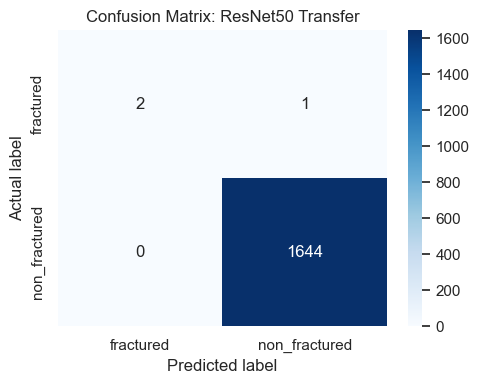

In [ ]:
evaluation_records = []
model_outputs = {}

# Iterate over each restored model, run validation inference, and collect metrics for comparison.
for entry in loaded_models:
    model = entry['model']
    name = entry['metadata']['model_name']
    metrics, details = evaluate_model(model, val_loader, name)
    evaluation_records.append({
        'Model': name,
        'Accuracy': metrics['accuracy'],
        'Precision (fractured)': metrics['precision'],
        'Recall (fractured)': metrics['recall'],
        'Specificity': metrics['specificity'],
        'F1 (fractured)': metrics['f1'],
        'ROC AUC (fractured)': metrics['roc_auc'],
        'Saved Validation Accuracy': entry['metadata']['saved_accuracy'],
    })
    # Persist prediction details for downstream visualizations (ROC/PR, confusion matrix, tuning).
    model_outputs[name] = details
    entry['metrics'] = metrics

evaluation_df = pd.DataFrame(evaluation_records)
if not evaluation_df.empty:
    evaluation_df = evaluation_df.sort_values(by='F1 (fractured)', ascending=False).reset_index(drop=True)
    print("\nModel comparison summary:")
    display(evaluation_df)
    best_model_name = evaluation_df.iloc[0]['Model']
    best_conf_matrix = model_outputs[best_model_name]['confusion_matrix']
    plt.figure(figsize=(5, 4))
    sns.heatmap(best_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=val_dataset.classes, yticklabels=val_dataset.classes)
    plt.title(f'Confusion Matrix: {best_model_name}')
    plt.xlabel('Predicted label')
    plt.ylabel('Actual label')
    plt.tight_layout()
    plt.show()
else:
    best_model_name = None
    print("No evaluation records available; check earlier steps.")

In [ ]:
if model_outputs:
    # Plot ROC curves to visualize sensitivity vs. false-positive trade-offs for each model.
    plt.figure(figsize=(6, 5))
    for name, details in model_outputs.items():
        y_true = details['labels']
        y_score = details['probabilities'][:, 0]
        fpr, tpr, _ = roc_curve(y_true, y_score, pos_label=0)
        plt.plot(fpr, tpr, label=f"{name}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
    plt.xlabel('False Positive Rate (non_fractured → fractured)')
    plt.ylabel('True Positive Rate (fractured)')
    plt.title('ROC curves across models')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot precision-recall curves focused on the fractured (positive) class to quantify alert precision.
    plt.figure(figsize=(6, 5))
    for name, details in model_outputs.items():
        y_true = details['labels']
        y_score = details['probabilities'][:, 0]
        precision, recall, _ = precision_recall_curve(y_true, y_score, pos_label=0)
        plt.plot(recall, precision, label=f"{name}")
    plt.xlabel('Recall (fractured)')
    plt.ylabel('Precision (fractured)')
    plt.title('Precision-Recall curves across models')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Print a compact AUC summary for quick inspection of ranking stability.
    roc_auc_summary = {name: roc_auc_score(1 - det['labels'], det['probabilities'][:, 0]) for name, det in model_outputs.items()}
    print("ROC AUC summary:")
    for name, auc in roc_auc_summary.items():
        print(f"  {name}: {auc:.4f}")
else:
    print("ROC/PR curves skipped because no evaluation outputs are available.")
print("Explanation: Week 6 visualization plots demonstrate fracture-detection sensitivity versus false-positive trade-offs for every model.")

### Week 7 – Probability threshold optimization

To fine-tune sensitivity versus specificity, the next cell searches for the probability threshold that maximizes the F1-score for the top-performing model.

## Week 7 – Performance optimization and interpretability

We finish by tuning decision thresholds and visualizing attention maps so end users can interpret every prediction.

In [ ]:
if best_model_name:
    best_outputs = model_outputs[best_model_name]
    labels = best_outputs['labels']
    probabilities_class0 = best_outputs['probabilities'][:, 0]
    # Sweep possible thresholds using precision-recall pairs to locate the F1-optimal decision point.
    precision_vals, recall_vals, thresholds = precision_recall_curve(labels, probabilities_class0, pos_label=0)
    f1_vals = (2 * precision_vals * recall_vals) / (precision_vals + recall_vals + 1e-8)
    if thresholds.size:
        best_index = int(np.nanargmax(f1_vals[:-1]))
        optimal_threshold = float(thresholds[best_index])
    else:
        optimal_threshold = 0.5
    tuned_predictions = np.where(probabilities_class0 >= optimal_threshold, 0, 1)
    # Recompute metrics using the tuned threshold to quantify impact without retraining.
    tuned_prob_matrix = np.column_stack([probabilities_class0, 1.0 - probabilities_class0])
    tuned_metrics = compute_metrics(labels, tuned_predictions, tuned_prob_matrix)
    print(f"Optimal probability threshold for {best_model_name}: {optimal_threshold:.3f}")
    print("Metrics after threshold tuning:")
    for metric_name, metric_value in tuned_metrics.items():
        print(f"  {metric_name}: {metric_value:.4f}")
else:
    print("Skipping threshold optimization because no evaluated models are available.")

Optimal probability threshold for ResNet50 Transfer: 0.883
Metrics after threshold tuning:
  accuracy: 0.9994
  precision: 1.0000
  recall: 0.6667
  f1: 0.8000
  specificity: 1.0000
  roc_auc: 0.9994
  sensitivity: 0.6667


### Week 7 – Grad-CAM utilities

The next cell defines Grad-CAM helpers for visual explanations, including image denormalization and activation-based heatmap generation targeted at the final convolutional blocks.

In [13]:
IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406])

IMAGENET_STD = torch.tensor([0.229, 0.224, 0.225])



def denormalize_image(tensor: torch.Tensor) -> torch.Tensor:

    """Undo ImageNet normalization for visualization."""

    tensor = tensor.clone().cpu()

    for channel in range(3):

        tensor[channel] = tensor[channel] * IMAGENET_STD[channel] + IMAGENET_MEAN[channel]

    return torch.clamp(tensor, 0, 1)



def upscale_cam(cam: torch.Tensor, target_size: Tuple[int, int]) -> torch.Tensor:

    """Resample a class activation map to the desired spatial resolution."""

    cam = cam.unsqueeze(1)

    cam = F.interpolate(cam, size=target_size, mode="bicubic", align_corners=False)

    cam = cam.squeeze(1)

    cam_min, cam_max = cam.min(), cam.max()

    return (cam - cam_min) / (cam_max - cam_min + 1e-8)



def generate_gradcam(model: nn.Module, input_tensor: torch.Tensor, target_layer: nn.Module) -> torch.Tensor:

    """Compute Grad-CAM activations for the chosen layer."""

    activations: List[torch.Tensor] = []

    gradients: List[torch.Tensor] = []



    def forward_hook(_module, _inputs, output):

        activations.append(output.detach())



    def backward_hook(_module, _grad_input, grad_output):

        gradients.append(grad_output[0].detach())



    forward_handle = target_layer.register_forward_hook(forward_hook)

    backward_handle = target_layer.register_full_backward_hook(backward_hook)



    model.zero_grad()

    outputs = model(input_tensor)

    predicted_indexes = outputs.argmax(dim=1)

    selected_scores = outputs[torch.arange(outputs.size(0)), predicted_indexes]

    selected_scores.sum().backward()



    forward_handle.remove()

    backward_handle.remove()



    activation = activations[0]

    gradient = gradients[0]

    weights = gradient.mean(dim=(2, 3), keepdim=True)

    cam = (weights * activation).sum(dim=1)

    cam = torch.relu(cam)

    return cam



def generate_gradient_attention(

    model: nn.Module,

    input_tensor: torch.Tensor,

    target_class: torch.Tensor | None = None,

) -> torch.Tensor:

    """Produce a gradient-based attention map (gradient * input magnitude)."""

    cloned_input = input_tensor.clone().detach().requires_grad_(True)

    outputs = model(cloned_input)

    if target_class is None:

        target_class = outputs.argmax(dim=1)

    selected_scores = outputs[torch.arange(outputs.size(0)), target_class]

    model.zero_grad()

    selected_scores.sum().backward()

    gradient = cloned_input.grad.detach()

    attention = (gradient * cloned_input).sum(dim=1).abs()

    attention_min, attention_max = attention.min(), attention.max()

    return (attention - attention_min) / (attention_max - attention_min + 1e-8)



def prepare_visualization(image_tensor: torch.Tensor, heatmap: torch.Tensor) -> Tuple[np.ndarray, np.ndarray]:

    """Convert tensors to NumPy arrays for matplotlib rendering."""

    image = denormalize_image(image_tensor)

    heatmap_np = heatmap.cpu().numpy()

    return image.permute(1, 2, 0).numpy(), heatmap_np


### Week 7 – Interpretability on validation samples

The final code cell runs Grad-CAM on a random subset of validation images using the ResNet model, overlaying heatmaps to highlight decision-driving regions.

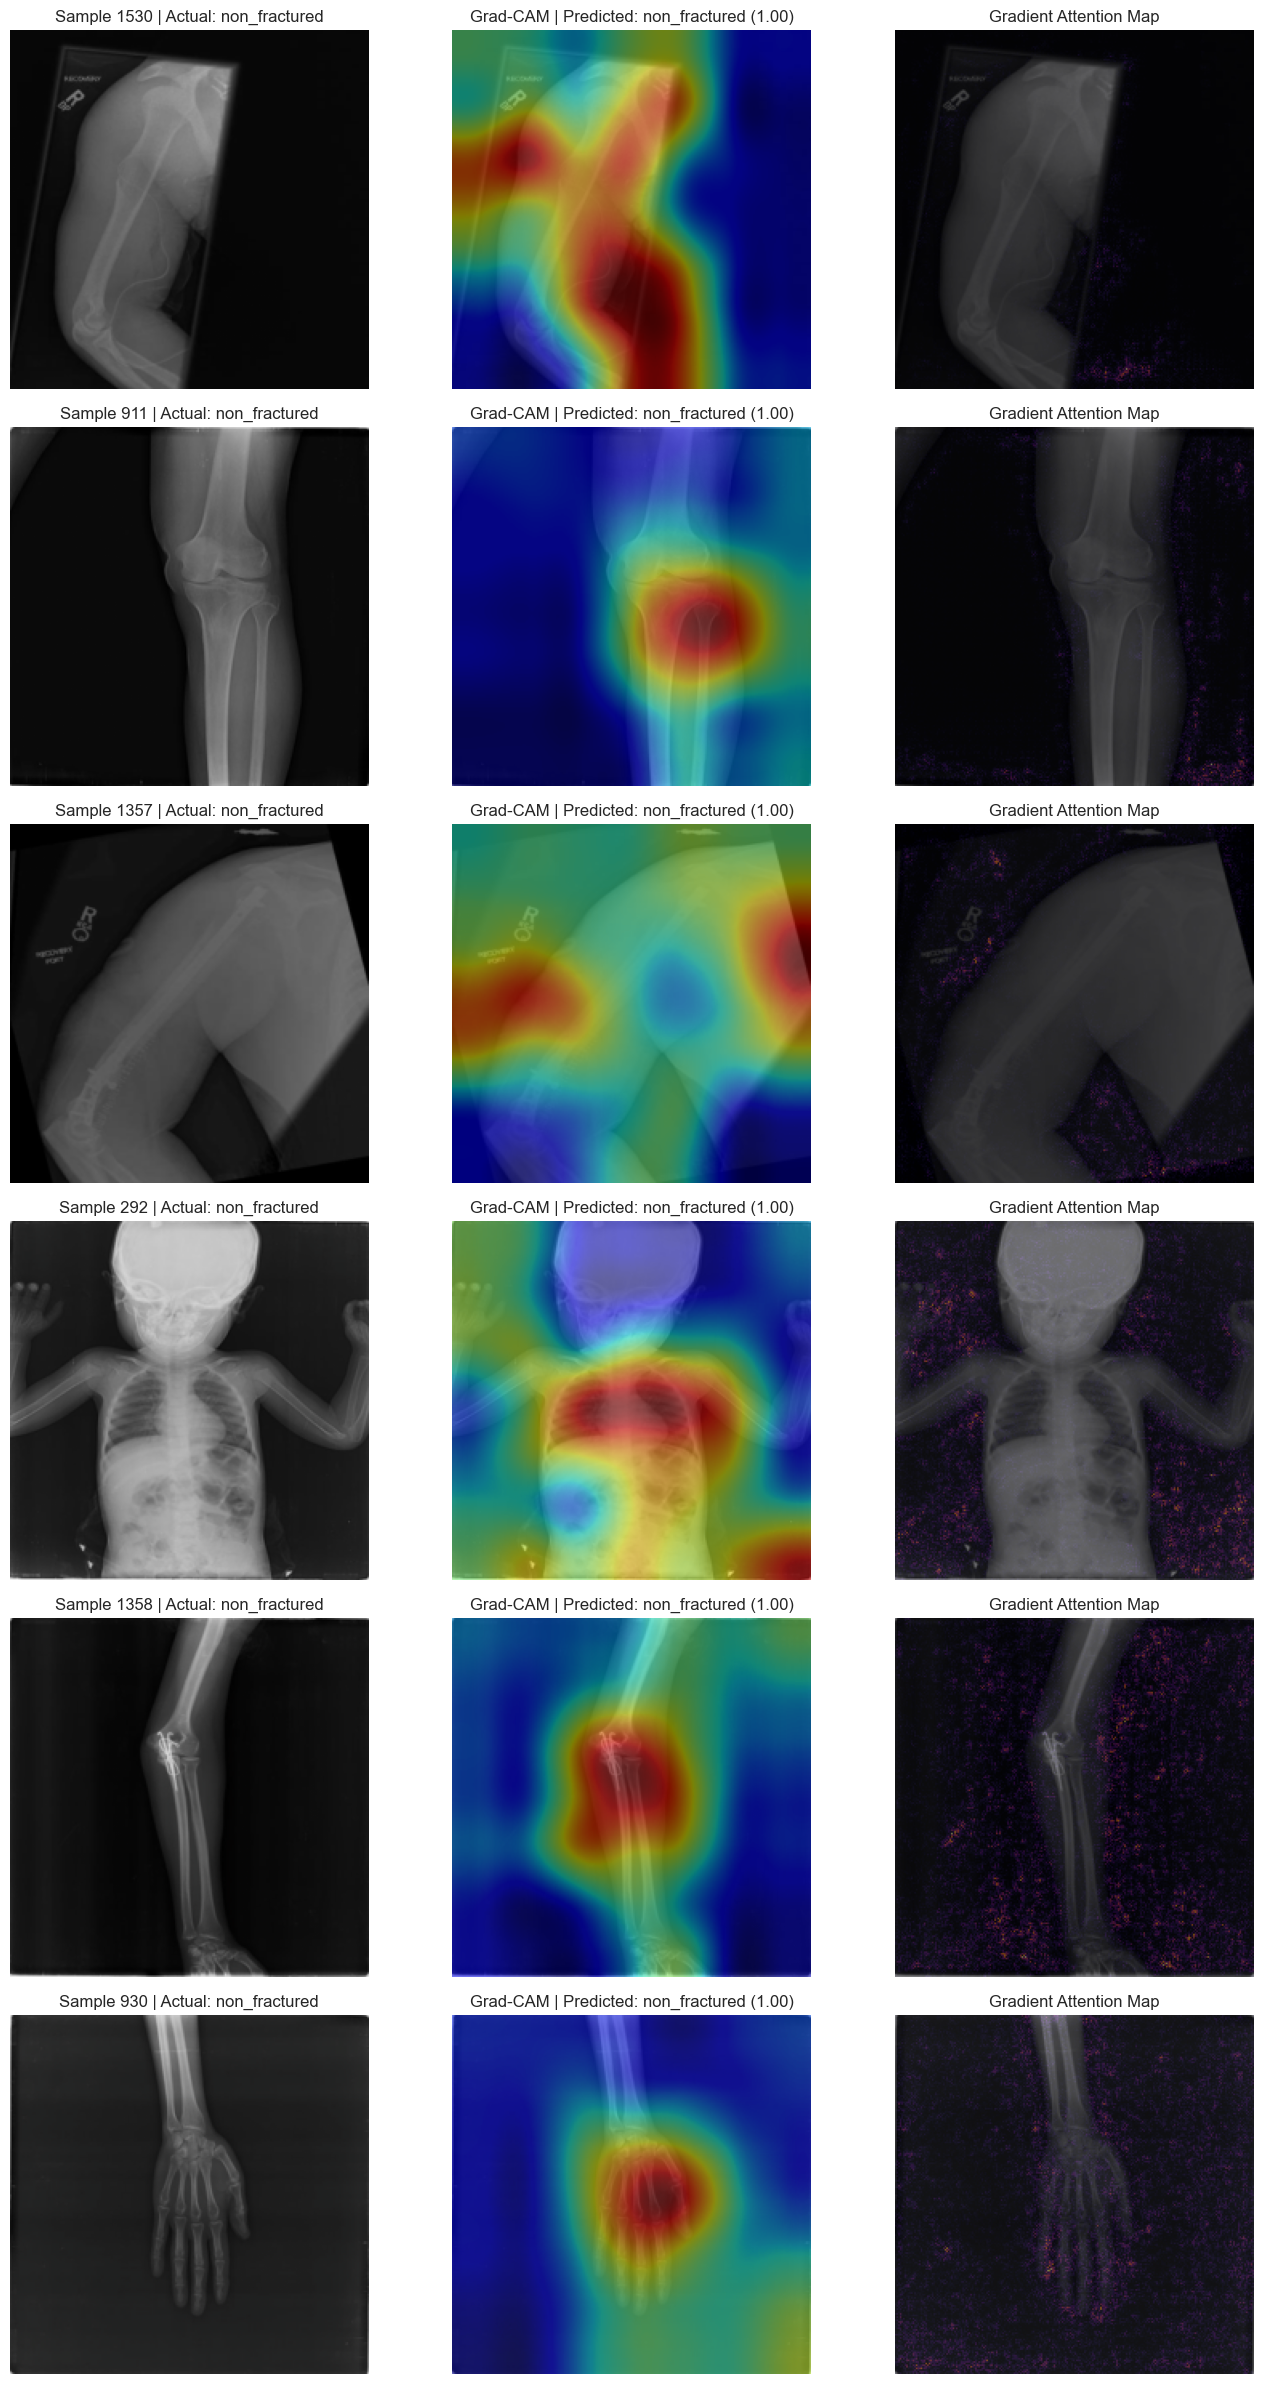

In [ ]:
resnet_entry = next((entry for entry in loaded_models if "ResNet" in entry["metadata"]["model_name"]), None)

if resnet_entry is None:
    print("ResNet model unavailable; Grad-CAM visualization skipped.")
else:
    resnet_model = resnet_entry["model"]
    resnet_model.eval()
    target_layer = resnet_model.resnet.layer4[-1]
    samples_to_visualize = min(6, len(val_dataset))
    if samples_to_visualize == 0:
        print("Validation dataset is empty; skipping Grad-CAM.")
    else:
        sampled_indices = np.random.choice(len(val_dataset), size=samples_to_visualize, replace=False)
        plt.figure(figsize=(14, 4 * samples_to_visualize))
        for row_index, sample_idx in enumerate(sampled_indices, start=1):
            image_tensor, label = val_dataset[sample_idx]
            input_tensor = image_tensor.unsqueeze(0).to(device)
            # Generate Grad-CAM and gradient-attention maps to highlight fracture-relevant regions.
            gradcam_raw = generate_gradcam(resnet_model, input_tensor, target_layer)
            gradcam_dense = upscale_cam(gradcam_raw, image_tensor.shape[1:])[0].detach()
            gradient_attention = generate_gradient_attention(resnet_model, input_tensor)[0].detach()
            with torch.no_grad():
                logits = resnet_model(input_tensor)
                probabilities = torch.softmax(logits, dim=1).cpu().numpy()[0]
            predicted_label = val_dataset.classes[int(np.argmax(probabilities))]
            confidence = float(np.max(probabilities))
            original_image, _ = prepare_visualization(image_tensor, gradcam_dense)
            gradcam_overlay = gradcam_dense.cpu().numpy()
            attention_overlay = gradient_attention.cpu().numpy()
            plt.subplot(samples_to_visualize, 3, 3 * row_index - 2)
            plt.imshow(original_image)
            plt.title(f"Sample {sample_idx} | Actual: {val_dataset.classes[label]}")
            plt.axis("off")
            plt.subplot(samples_to_visualize, 3, 3 * row_index - 1)
            plt.imshow(original_image)
            plt.imshow(gradcam_overlay, cmap="jet", alpha=0.5, vmin=0.0, vmax=1.0)
            plt.title(f"Grad-CAM | Predicted: {predicted_label} ({confidence:.2f})")
            plt.axis("off")
            plt.subplot(samples_to_visualize, 3, 3 * row_index)
            plt.imshow(original_image)
            plt.imshow(attention_overlay, cmap="inferno", alpha=0.45, vmin=0.0, vmax=attention_overlay.max())
            plt.title("Gradient Attention Map")
            plt.axis("off")
        plt.tight_layout()
        plt.show()

## Summary

This consolidated notebook covers dataset maintenance, loader construction, model restoration, comparative evaluation, threshold tuning, and interpretability, delivering the same analytical surface area as the weekly experiments in a single reproducible workflow.

### Appendix – Cell-wise explanations

| Code Cell | Section focus | Key actions |
| --- | --- | --- |
| 1 | Week 1 – Environment initialization | Imports core libraries, seeds randomness, selects the active device, and notes EfficientNet availability. |
| 2 | Week 1 – Dataset configuration | Resolves project paths, validates training/validation directories, and reports readiness of the organized dataset. |
| 3 | Week 1 – Dataset exploration | Counts per-class samples, prints totals, and surfaces representative filenames for quick manual inspection. |
| 4 | Optional dataset consolidation | Defines a guarded rebuild utility for regenerating the combined dataset from YOLO and FracAtlas sources. |
| 5 | Week 2 – Dataset utilities | Implements balanced and lenient dataset wrappers plus sampling helpers to stabilize training inputs. |
| 6 | Week 2 – Transforms and loaders | Builds augmentation/transforms, constructs training and validation DataLoaders, and logs resulting distributions. |
| 7 | Week 3 – Metric helpers | Provides reusable inference, metric computation, and reporting routines shared by every model. |
| 8 | Week 3 – Model architectures | Reconstructs the SimpleCNN baseline and transfer models with optional feature freezing. |
| 9 | Week 3 – Baseline training toggle | Offers an optional quick retraining loop for the baseline CNN with validation reporting. |
| 10 | Week 4 – Transfer fine-tune toggle | Enables on-demand fine-tuning of the ResNet transfer model while keeping heavy runs optional. |
| 11 | Week 5 – Hyperparameter review | Parses cached search logs, surfaces top-performing configurations, and presents their metrics. |
| 12 | Week 4 – Checkpoint loading | Restores saved checkpoints for baseline, ResNet, and EfficientNet models and records metadata. |
| 13 | Week 6 – Validation evaluation | Evaluates each loaded model, aggregates metrics, and plots the confusion matrix for the leader. |
| 14 | Week 6 – ROC/PR visualization | Draws ROC and precision-recall curves for all models and prints AUC summaries. |
| 15 | Week 7 – Threshold tuning | Searches for the F1-maximizing probability threshold and reports tuned metrics. |
| 16 | Week 7 – Grad-CAM utilities | Defines Grad-CAM, gradient attention, and visualization helpers for interpretability. |
| 17 | Week 7 – Interpretability demos | Generates Grad-CAM and gradient attention overlays on sampled validation images using ResNet. |